# Cost Impact – Quantifying Business Value

This notebook translates model decisions into **estimated business impact**.

The goal is to answer stakeholder questions such as:
- How much fraud loss can we prevent?
- How much revenue do we lose due to false positives?
- What is the operational cost of manual review?
- Which policy thresholds produce the best overall business outcome?

This is where the project moves from “a working model”
to a **business case**.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# Load dataset
paths = ["data/creditcard.csv", "creditcard.csv"]
data_path = next((p for p in paths if os.path.exists(p)), None)

if data_path is None:
    raise FileNotFoundError("creditcard.csv not found.")

df = pd.read_csv(data_path)
df.shape


(284807, 31)

## Business Assumptions (Illustrative)

Exact costs vary by company and market.  
We define reasonable illustrative assumptions to compare policies consistently.

Cost components:
- **Missed fraud (FN):** direct financial loss per fraudulent transaction allowed
- **False block (FP in Block):** customer friction and lost conversion
- **Manual review:** operational cost per reviewed transaction

These assumptions are not meant to be “true” for all companies,
but to provide a **decision framework** that can be tuned.


In [2]:
X = df.drop(columns=["Class"])
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

risk_scores = model.predict_proba(X_test)[:, 1]


## Decision Policy (Block / Review / Allow)

We evaluate a tiered policy:
- **Block** high-risk transactions (high friction, strong control)
- **Review** medium-risk transactions (manual capacity)
- **Allow** low-risk transactions (seamless conversion)

This matches real-world fraud operations.


In [3]:
def decision_policy(score, t_block, t_review):
    if score >= t_block:
        return "block"
    elif score >= t_review:
        return "review"
    else:
        return "allow"

T_BLOCK = 0.8
T_REVIEW = 0.3

decisions = np.array([decision_policy(s, T_BLOCK, T_REVIEW) for s in risk_scores])

policy_df = pd.DataFrame({
    "risk_score": risk_scores,
    "decision": decisions,
    "actual": y_test.values
})

policy_df.head()


,risk_score,decision,actual
0,0.000145,allow,0
1,0.000601,allow,0
2,0.013042,allow,0
3,0.000995,allow,0
4,0.000916,allow,0


## Operational Rates

These rates directly map to real business impact:
- **Block rate:** customer friction + support cost
- **Review rate:** queue size and SLA pressure
- **Allow rate:** conversion and user experience

A policy is only feasible if these rates match real operational capacity.
"

In [4]:
action_rates = policy_df["decision"].value_counts(normalize=True).rename("rate").to_frame()
action_rates


,rate
decision,
allow,0.997203
block,0.001697
review,0.001100


In [5]:
bucket_stats = (
    policy_df.groupby("decision")["actual"]
    .agg(count="count", fraud_rate="mean")
    .sort_values("fraud_rate", ascending=False)
)
bucket_stats


,count,fraud_rate
decision,,
block,145,0.806897
review,94,0.085106
allow,85204,0.000270


## Cost Function (Business Objective)

We compute estimated total cost as:

**Total Cost =**
- (Missed fraud count) × (cost per missed fraud)
- + (False blocks count) × (cost per false block)
- + (Review count) × (cost per review)

This enables direct comparison across policies.


In [6]:
COST_MISSED_FRAUD = 500     # cost per allowed fraud (FN)
COST_FALSE_BLOCK = 10       # cost per blocked legit (FP within "block")
COST_REVIEW = 3             # cost per reviewed transaction

def compute_cost_breakdown(df):
    missed_fraud = df[(df["decision"] == "allow") & (df["actual"] == 1)].shape[0]
    false_blocks = df[(df["decision"] == "block") & (df["actual"] == 0)].shape[0]
    reviews = df[df["decision"] == "review"].shape[0]

    total_cost = (
        missed_fraud * COST_MISSED_FRAUD
        + false_blocks * COST_FALSE_BLOCK
        + reviews * COST_REVIEW
    )

    return {
        "missed_fraud": missed_fraud,
        "false_blocks": false_blocks,
        "reviews": reviews,
        "estimated_total_cost": total_cost
    }

baseline_cost = compute_cost_breakdown(policy_df)
baseline_cost


{'missed_fraud': 23,
 'false_blocks': 28,
 'reviews': 94,
 'estimated_total_cost': 12062}

## Policy Search

We search across possible (t_block, t_review) values to find policies that:
- minimize estimated total cost,
- keep review volume within realistic limits.

This mirrors how risk teams tune policies under business constraints.


In [7]:
t_blocks = np.round(np.linspace(0.6, 0.95, 8), 2)
t_reviews = np.round(np.linspace(0.05, 0.6, 12), 2)

rows = []

for tb in t_blocks:
    for tr in t_reviews:
        if tr >= tb:
            continue

        tmp = policy_df.copy()
        tmp["decision"] = np.array([decision_policy(s, tb, tr) for s in tmp["risk_score"]])

        costs = compute_cost_breakdown(tmp)

        rows.append({
            "t_block": tb,
            "t_review": tr,
            "block_rate": (tmp["decision"] == "block").mean(),
            "review_rate": (tmp["decision"] == "review").mean(),
            "allow_rate": (tmp["decision"] == "allow").mean(),
            **costs
        })

grid_df = pd.DataFrame(rows).sort_values("estimated_total_cost")
grid_df.head(15)


,t_block,t_review,block_rate,review_rate,allow_rate,missed_fraud,false_blocks,reviews,estimated_total_cost
87,0.95,0.25,0.001475,0.001615,0.996910,21,14,138,11054
75,0.90,0.25,0.001627,0.001463,0.996910,21,23,125,11105
63,0.85,0.25,0.001650,0.001440,0.996910,21,24,123,11109
51,0.80,0.25,0.001697,0.001393,0.996910,21,28,119,11137
39,0.75,0.25,0.001767,0.001323,0.996910,21,32,113,11159
27,0.70,0.25,0.001814,0.001276,0.996910,21,34,109,11167
86,0.95,0.20,0.001475,0.002153,0.996372,21,14,184,11192
15,0.65,0.25,0.001908,0.001182,0.996910,21,42,101,11223
74,0.90,0.20,0.001627,0.002001,0.996372,21,23,171,11243
62,0.85,0.20,0.001650,0.001978,0.996372,21,24,169,11247


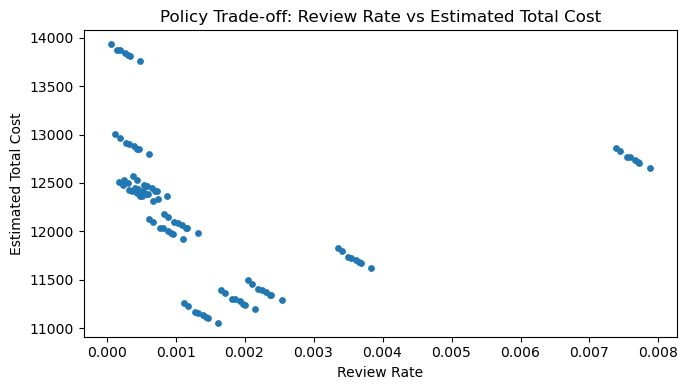

In [8]:
plt.figure(figsize=(7, 4))
plt.scatter(grid_df["review_rate"], grid_df["estimated_total_cost"], s=15)
plt.title("Policy Trade-off: Review Rate vs Estimated Total Cost")
plt.xlabel("Review Rate")
plt.ylabel("Estimated Total Cost")
plt.tight_layout()
plt.show()


## Capacity-Aware Selection

In practice, review teams have finite capacity.
We therefore choose the best (lowest-cost) policy under a review constraint.

Example:
If we can only review up to **1%** of transactions,
we filter policies with review_rate <= 0.01.


In [9]:
MAX_REVIEW_RATE = 0.01

best_under_capacity = grid_df[grid_df["review_rate"] <= MAX_REVIEW_RATE].head(10)
best_under_capacity


,t_block,t_review,block_rate,review_rate,allow_rate,missed_fraud,false_blocks,reviews,estimated_total_cost
87,0.95,0.25,0.001475,0.001615,0.996910,21,14,138,11054
75,0.90,0.25,0.001627,0.001463,0.996910,21,23,125,11105
63,0.85,0.25,0.001650,0.001440,0.996910,21,24,123,11109
51,0.80,0.25,0.001697,0.001393,0.996910,21,28,119,11137
39,0.75,0.25,0.001767,0.001323,0.996910,21,32,113,11159
27,0.70,0.25,0.001814,0.001276,0.996910,21,34,109,11167
86,0.95,0.20,0.001475,0.002153,0.996372,21,14,184,11192
15,0.65,0.25,0.001908,0.001182,0.996910,21,42,101,11223
74,0.90,0.20,0.001627,0.002001,0.996372,21,23,171,11243
62,0.85,0.20,0.001650,0.001978,0.996372,21,24,169,11247


## Policy Recommendation (Stakeholder Summary)

A recommended policy should:
- stay within review capacity,
- keep block rate reasonable (avoid harming conversion),
- minimize estimated total cost.

Importantly, thresholds are business levers:
they can be adjusted when fraud volume spikes or when conversion is prioritized.


In [10]:
if len(best_under_capacity) > 0:
    rec = best_under_capacity.iloc[0].to_dict()
    rec
else:
    print("No policy found under the review capacity constraint. Increase MAX_REVIEW_RATE or broaden the grid.")


## Key Takeaways

- Business value should be measured in **cost and operational impact**, not only ML metrics.
- Cost-aware policy optimization allows stakeholders to choose thresholds transparently.
- Review capacity constraints are first-class requirements in fraud operations.
- The same risk model can support different business strategies through policy thresholds.

> The model predicts risk.  
> The policy decides how the business acts on that risk.
